In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

^C


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
from coco_final_labels_transfer import labels as coco_labels_transfer
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-17 21:54:16.214229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 21:54:16.220523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 21:54:16.220730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'
TRANSFER_TRAIN_IMAGES ='data/transfer_train'
TRANSFER_VAL_IMAGES = 'data/transfer_val'
BATCH_SIZE = 16

In [3]:
resnet50 = keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

2022-07-18 00:37:17.102553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:37:17.110027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:37:17.110299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:37:17.110823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [4]:
#LAMBDA FUNCTIONS CANNOT BE LOADED!!
def distance_layer(vectors):
    (features_A, features_B) = vectors
    sum_squared = K.sum(K.square(features_A - features_B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

class DistanceLayer2(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        return ap_distance

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_19 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['input_18[0][0]',               
                                                                  'input_19[0][0]']         

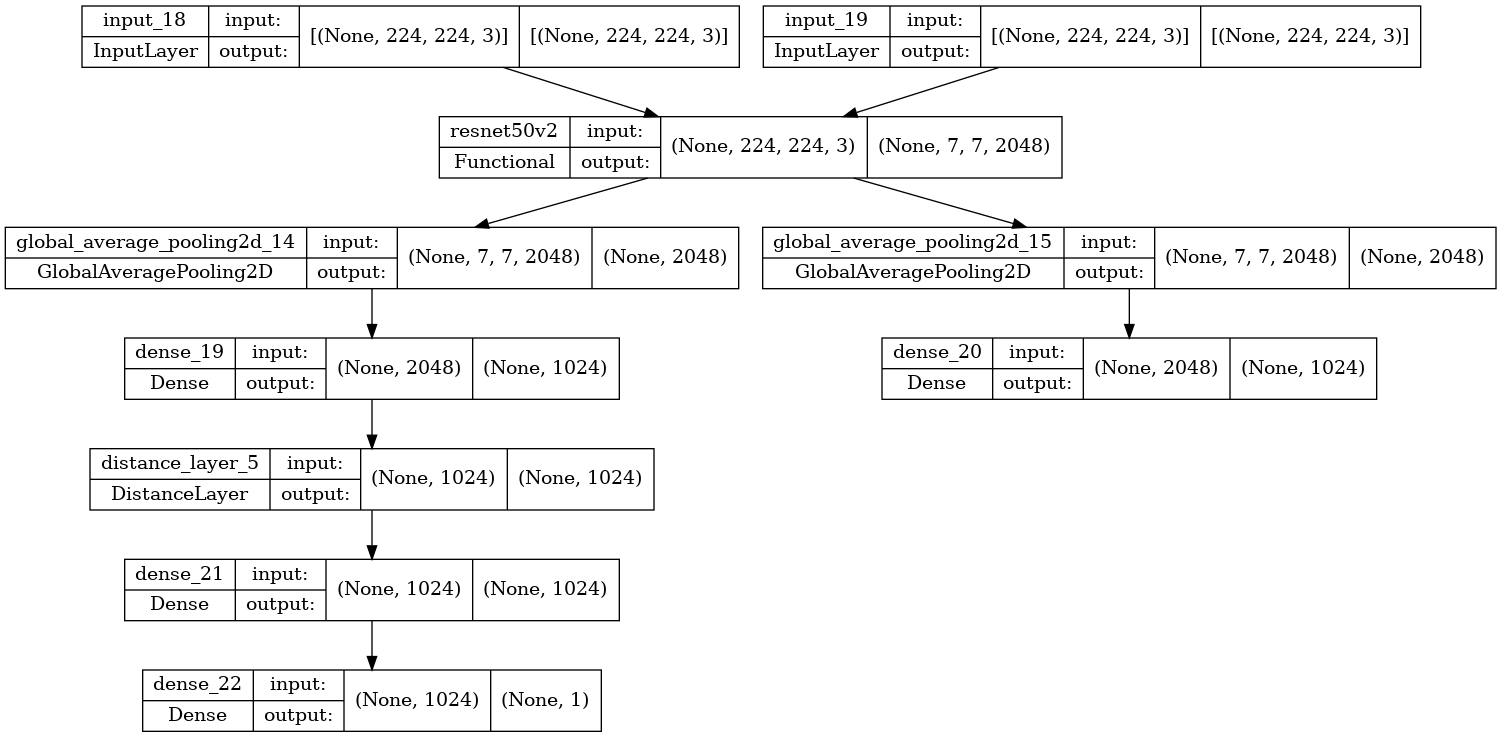

In [13]:
input_a = Input(shape=(224,224,3))
input_b = Input(shape=(224,224,3))

features_a = resnet50(input_a)
features_a = GlobalAveragePooling2D()(features_a)
features_a = Dense(1024, activation="relu")(features_a)

features_b = resnet50(input_b)
features_b = GlobalAveragePooling2D()(features_b)
features_b = Dense(1024, activation="relu")(features_b)

#distance = Lambda(distance_layer)([features_a, features_b])


siamese = DistanceLayer()
distance = siamese(features_a, features_b)
#distance = Flatten()(distance)
distance = Dense(1024, activation="relu")(distance)
output = Dense(1, activation="sigmoid")(distance)
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

siamese_model.summary()
tf.keras.utils.plot_model(siamese_model, to_file="logs/siamese/siamese_initial.png", show_shapes=True, expand_nested=False)

In [14]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

transfer_train_files = {}
for d in os.listdir(TRANSFER_TRAIN_IMAGES):
    files = os.listdir(f"{TRANSFER_TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        transfer_train_files[d] = files

print(len(transfer_train_files))

transfer_val_files = {}
for d in os.listdir(TRANSFER_VAL_IMAGES):
    files = os.listdir(f"{TRANSFER_VAL_IMAGES}/{d}")
    if len(files) > 0:
        transfer_val_files[d] = files

print(len(transfer_val_files))

80
80
6
6


In [15]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, validation, label):
    return ((load_images(anchor), load_images(validation)), label)

In [16]:
def get_training_data(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    X_a = []
    X_b = []
    Y = []

    available_classes = labels

    if training:
        for i in range(int(epoch_size/2)):
            c = random.choice(available_classes)
            n = random.choice([d for d in available_classes if d is not c])
            anchor = random.choice(train_files[c])
            positive = random.choice(train_files[c])
            negative = random.choice(train_files[n])

            X_a.append(f"{TRAIN_IMAGES}/{c}/{anchor}")
            X_a.append(f"{TRAIN_IMAGES}/{c}/{anchor}")
            X_b.append(f"{TRAIN_IMAGES}/{c}/{positive}")
            X_b.append(f"{TRAIN_IMAGES}/{n}/{negative}")
            Y.append(1)
            Y.append(0)

    if transfer:
        for i in range(int(epoch_size/2/80)):
            c = random.choice(available_classes)
            n = random.choice([d for d in available_classes if d is not c])
            anchor = random.choice(transfer_train_files[c])
            positive = random.choice(transfer_train_files[c])
            negative = random.choice(transfer_train_files[n])

            X_a.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{anchor}")
            X_a.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{anchor}")
            X_b.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{positive}")
            X_b.append(f"{TRANSFER_TRAIN_IMAGES}/{n}/{negative}")
            Y.append(1)
            Y.append(0)

    return (X_a, X_b, Y)

def get_training_dataset(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    data = get_training_data(labels, epoch_size, training, transfer)
    a = tf.data.Dataset.from_tensor_slices(data[0])
    b = tf.data.Dataset.from_tensor_slices(data[1])
    y = tf.data.Dataset.from_tensor_slices(data[2])
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data

def get_validation_dataset(labels, training: bool=True, transfer: bool=False):
    X_a = []
    X_b = []
    Y = []
    if training:
        for c in labels:
            for file in val_files[c]:
                anchor = file
                positive = random.choice(val_files[c])
                negative_class = random.choice([d for d in labels if d is not c])
                negative = random.choice(val_files[negative_class])
                X_a.append(f"{VAL_IMAGES}/{c}/{anchor}")
                X_a.append(f"{VAL_IMAGES}/{c}/{anchor}")
                X_b.append(f"{VAL_IMAGES}/{c}/{positive}")
                X_b.append(f"{VAL_IMAGES}/{negative_class}/{negative}")
                Y.append(1)
                Y.append(0)

    if transfer:
        for c in labels:
            for file in transfer_val_files[c]:
                anchor = file
                positive = random.choice(transfer_val_files[c])
                negative_class = random.choice([d for d in labels if d is not c])
                negative = random.choice(transfer_val_files[negative_class])
                X_a.append(f"{TRANSFER_VAL_IMAGES}/{c}/{anchor}")
                X_a.append(f"{TRANSFER_VAL_IMAGES}/{c}/{anchor}")
                X_b.append(f"{TRANSFER_VAL_IMAGES}/{c}/{positive}")
                X_b.append(f"{TRANSFER_VAL_IMAGES}/{negative_class}/{negative}")
                Y.append(1)
                Y.append(0)

    a = tf.data.Dataset.from_tensor_slices(X_a)
    b = tf.data.Dataset.from_tensor_slices(X_b)
    y = tf.data.Dataset.from_tensor_slices(Y)
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data

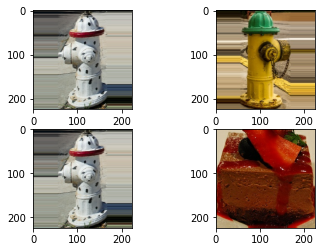

In [22]:
data = get_training_dataset(coco_labels, 8, True).as_numpy_iterator()

img_batch = next(data)
fig, (ax1, ax2) = plt.pyplot.subplots(2,2)
ax1[0].imshow(img_batch[0][0])
ax1[1].imshow(img_batch[0][1])
img_batch = next(data)
ax2[0].imshow(img_batch[0][0])
ax2[1].imshow(img_batch[0][1])

In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)
siamese_model.compile(loss=binary_cross_loss, optimizer=opt, metrics=METRICS)

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/siamese

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/siamese/{0}'.format(current_time)
weight_dir = 'weights/siamese/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_precision',
    mode='max',
    save_best_only=True)

Reusing TensorBoard on port 6007 (pid 534787), started 1 day, 0:17:30 ago. (Use '!kill 534787' to kill it.)

In [25]:

train_data = get_training_dataset(coco_labels, 4096*8, True, False)
train_data = train_data.shuffle(BATCH_SIZE*10)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(BATCH_SIZE)

val_data = get_validation_dataset(coco_labels, True, False)
val_data = val_data.shuffle(BATCH_SIZE*40, seed=1234)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(BATCH_SIZE)

    #print(len(data[2]))
loss = siamese_model.fit(train_data, batch_size=BATCH_SIZE, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback])
print(loss)

Epoch 1/20


2022-07-18 00:51:48.322944: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-07-18 00:51:48.767494: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-18 00:51:49.774298: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2048/2048 [==============================] - ETA: 0s - loss: 0.5684 - tp: 11462.0000 - fp: 5235.0000 - tn: 11149.0000 - fn: 4922.0000 - accuracy: 0.6900 - precision: 0.6865 - recall: 0.6996 - auc: 0.7700 - prc: 0.7607

2022-07-18 01:00:41.718872: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/siamese/20220718-005132/assets
2048/2048 [==============================] - 546s 263ms/step - loss: 0.5684 - tp: 11462.0000 - fp: 5235.0000 - tn: 11149.0000 - fn: 4922.0000 - accuracy: 0.6900 - precision: 0.6865 - recall: 0.6996 - auc: 0.7700 - prc: 0.7607 - val_loss: 0.4973 - val_tp: 12344.0000 - val_fp: 4048.0000 - val_tn: 11957.0000 - val_fn: 3661.0000 - val_accuracy: 0.7592 - val_precision: 0.7531 - val_recall: 0.7713 - val_auc: 0.8396 - val_prc: 0.8303
Epoch 2/20
2048/2048 [==============================] - 529s 258ms/step - loss: 0.4412 - tp: 13177.0000 - fp: 3590.0000 - tn: 12794.0000 - fn: 3207.0000 - accuracy: 0.7926 - precision: 0.7859 - recall: 0.8043 - auc: 0.8753 - prc: 0.8683 - val_loss: 0.4635 - val_tp: 12627.0000 - val_fp: 3489.0000 - val_tn: 12516.0000 - val_fn: 3378.0000 - val_accuracy: 0.7855 - val_precision: 0.7835 - val_recall: 0.7889 - val_auc: 0.8674 - val_prc: 0.8622
Epoch 3/20
2048/2048 [==============================]

In [26]:
#siamese_model.save_weights(os.path.join("weights/siamese_pretrained", "model"))
siamese_model.save(os.path.join("weights/siamese_pretrained", "siamese_train2"))
#siamese_model = tf.keras.models.load_model(os.path.join("weights/siamese_pretrained", "siamesev3"))

INFO:tensorflow:Assets written to: weights/siamese_pretrained/siamese_train2/assets


In [29]:
MAX_ANCHORS = 4

In [21]:
#save anchors for predictions later
import shutil


for dir in os.listdir(TRAIN_IMAGES):
    count = 0
    for file in os.listdir(os.path.join(TRAIN_IMAGES, dir)):
        c = dir

        if not os.path.exists(f'data/siamese_anchors/{c}'):
            os.mkdir(f'data/siamese_anchors/{c}')

        shutil.copyfile(os.path.join(TRAIN_IMAGES, dir, file), f'data/siamese_anchors/{c}/{file}')
        count += 1

        print(count)

        if count >= MAX_ANCHORS:
            break

# for subdir, dirs, files in os.walk(TRAIN_IMAGES):
#     for file in files:
#         c = subdir.split("/")[-1]
#         if not os.path.exists(f'data/siamese_anchors/{c}'):
#             os.mkdir(f'data/siamese_anchors/{c}')
#         shutil.copyfile(os.path.join(subdir, file), f'data/siamese_anchors/{c}/{file}')
#         count += 1

#         if count > MAX_ANCHORS:
#             break

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4


In [27]:
#siamese_model = tf.keras.models.load_model(os.path.join("weights/siamese_pretrained", "siamesev3"))
siamese_model = tf.keras.models.load_model(os.path.join("weights/siamese_pretrained", "siamese_train2"))
anchors = {}
for c in coco_labels:
    anchors[c] = []
    for image in os.listdir(f'data/siamese_anchors/{c}'):
        anchors[c].append(f'data/siamese_anchors/{c}/{image}')
        print(image)

# test_data = get_training_dataset(36000, False)
# test_data = test_data.batch(32)
# test_data = test_data.prefetch(32)
# siamese_model.evaluate(test_data)

1657668019367000000429593.jpg
1657668116958000000084689.jpg
1657668040578000000255315.jpg
1657668042909000000471816.jpg
1657668212303000000411931.jpg
1657668212194000000580851.jpg
1657668024855000000026828.jpg
1657668485219000000008761.jpg
1657668390151000000497698.jpg
1657668390101000000264618.jpg
1657668390092000000330513.jpg
1657668067439000000256309.jpg
1657668396407000000204969.jpg
1657668396156000000146878.jpg
1657668068386000000157184.jpg
1657668396104000000554471.jpg
1657667895176000000453138.jpg
1657668129941000000197886.jpg
1657667912415000000386313.jpg
1657668129117000000187509.jpg
1657667947439000000407039.jpg
1657668336994000000271231.jpg
1657668335401000000520005.jpg
1657668335769000000237721.jpg
1657668187733000000496683.jpg
1657668187649000000538167.jpg
1657668188063000000488657.jpg
1657668187416000000169330.jpg
1657668467832000000448161.jpg
1657668338129000000203107.jpg
1657667967965000000022801.jpg
1657668338363000000443033.jpg
1657668169464000000072961.jpg
1657668494

In [30]:
import glob

val_files = glob.glob(f'{VAL_IMAGES}/*/*.jpg')

print(len(val_files))
#Y = []
#Y_hat = []

support_set = []
for anchor in coco_labels:
    for x_img in anchors[anchor]:
        support_set.append(load_images(x_img))

f = open("siamese_predictions2.txt", "w")
for file in val_files:
    y_img = load_images(file)
    y_img = [y_img for _ in range(len(support_set))]

    preds = siamese_model.predict_on_batch([np.array(support_set), np.array(y_img)])
    avg_preds = []
    for i in range(0, len(support_set), MAX_ANCHORS):
        avg_preds.append(np.average(preds[i:i+MAX_ANCHORS]))

    label = coco_labels.index(file.split('/')[-2])
    guess = np.argmax(np.array(avg_preds))

    #Y.append(coco_labels.index(file.split('/')[-2]))
    #Y_hat.append(np.argmax(np.array(preds)))
    f.write(f'{label}:{guess}:{file}:{[p for p in avg_preds]}\n')

f.close()
    #print(f'{Y[-1]} : {Y_hat[-1]}')

# for file in val_files:
#     preds = []
#     X_1 = []
#     X_2 = []
#     y_img = load_images(file)
#     for anchor in coco_labels:
#         for x_img in anchors[anchor]:
#             X_1.append(load_images(x_img))
#             X_2 = y_img
    
#     preds = siamese_model.predict([np.array(X_1).reshape(-1,224,224,3), np.array(X_2).reshape(-1,224,224,3)])
    
#     Y.append(coco_labels.index(file.split('/')[-2]))
#     Y_hat.append(np.argmax(np.array(preds)))
#     print(f'{Y[-1]} : {Y_hat[-1]}')
    
#for anchor in
    #preds = siamese_model.predict([X, Y])

16005


In [18]:
import itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.pyplot.rcParams.update({'font.size': 10})
    figure = plt.pyplot.figure(figsize=(30, 30))
    plt.pyplot.imshow(cm, interpolation='nearest', cmap=plt.pyplot.cm.Blues)
    plt.pyplot.title("Confusion matrix")
    plt.pyplot.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.pyplot.xticks(tick_marks, class_names, rotation=90)
    plt.pyplot.yticks(tick_marks, class_names)
    
    cm = np.array(cm)
    cm = np.nan_to_num(0)
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=0)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    # threshold = cm.max() / 2.
    
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     color = "white" if cm[i, j] > threshold else "black"
    #     plt.pyplot.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.pyplot.tight_layout()
    plt.pyplot.ylabel('True label')
    plt.pyplot.xlabel('Predicted label')
    plt.pyplot.savefig('siamese-confision-matrix.jpg')
    return figure

/tmp/ipykernel_1053873/4262207280.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


[[0.2729805  0.         0.         ... 0.02777778 0.02       0.        ]
 [0.         0.375      0.         ... 0.         0.         0.        ]
 [0.00278552 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05555556 0.         0.        ]
 [0.00278552 0.125      0.         ... 0.         0.         0.03      ]
 [0.         0.         0.         ... 0.         0.         0.34333333]]


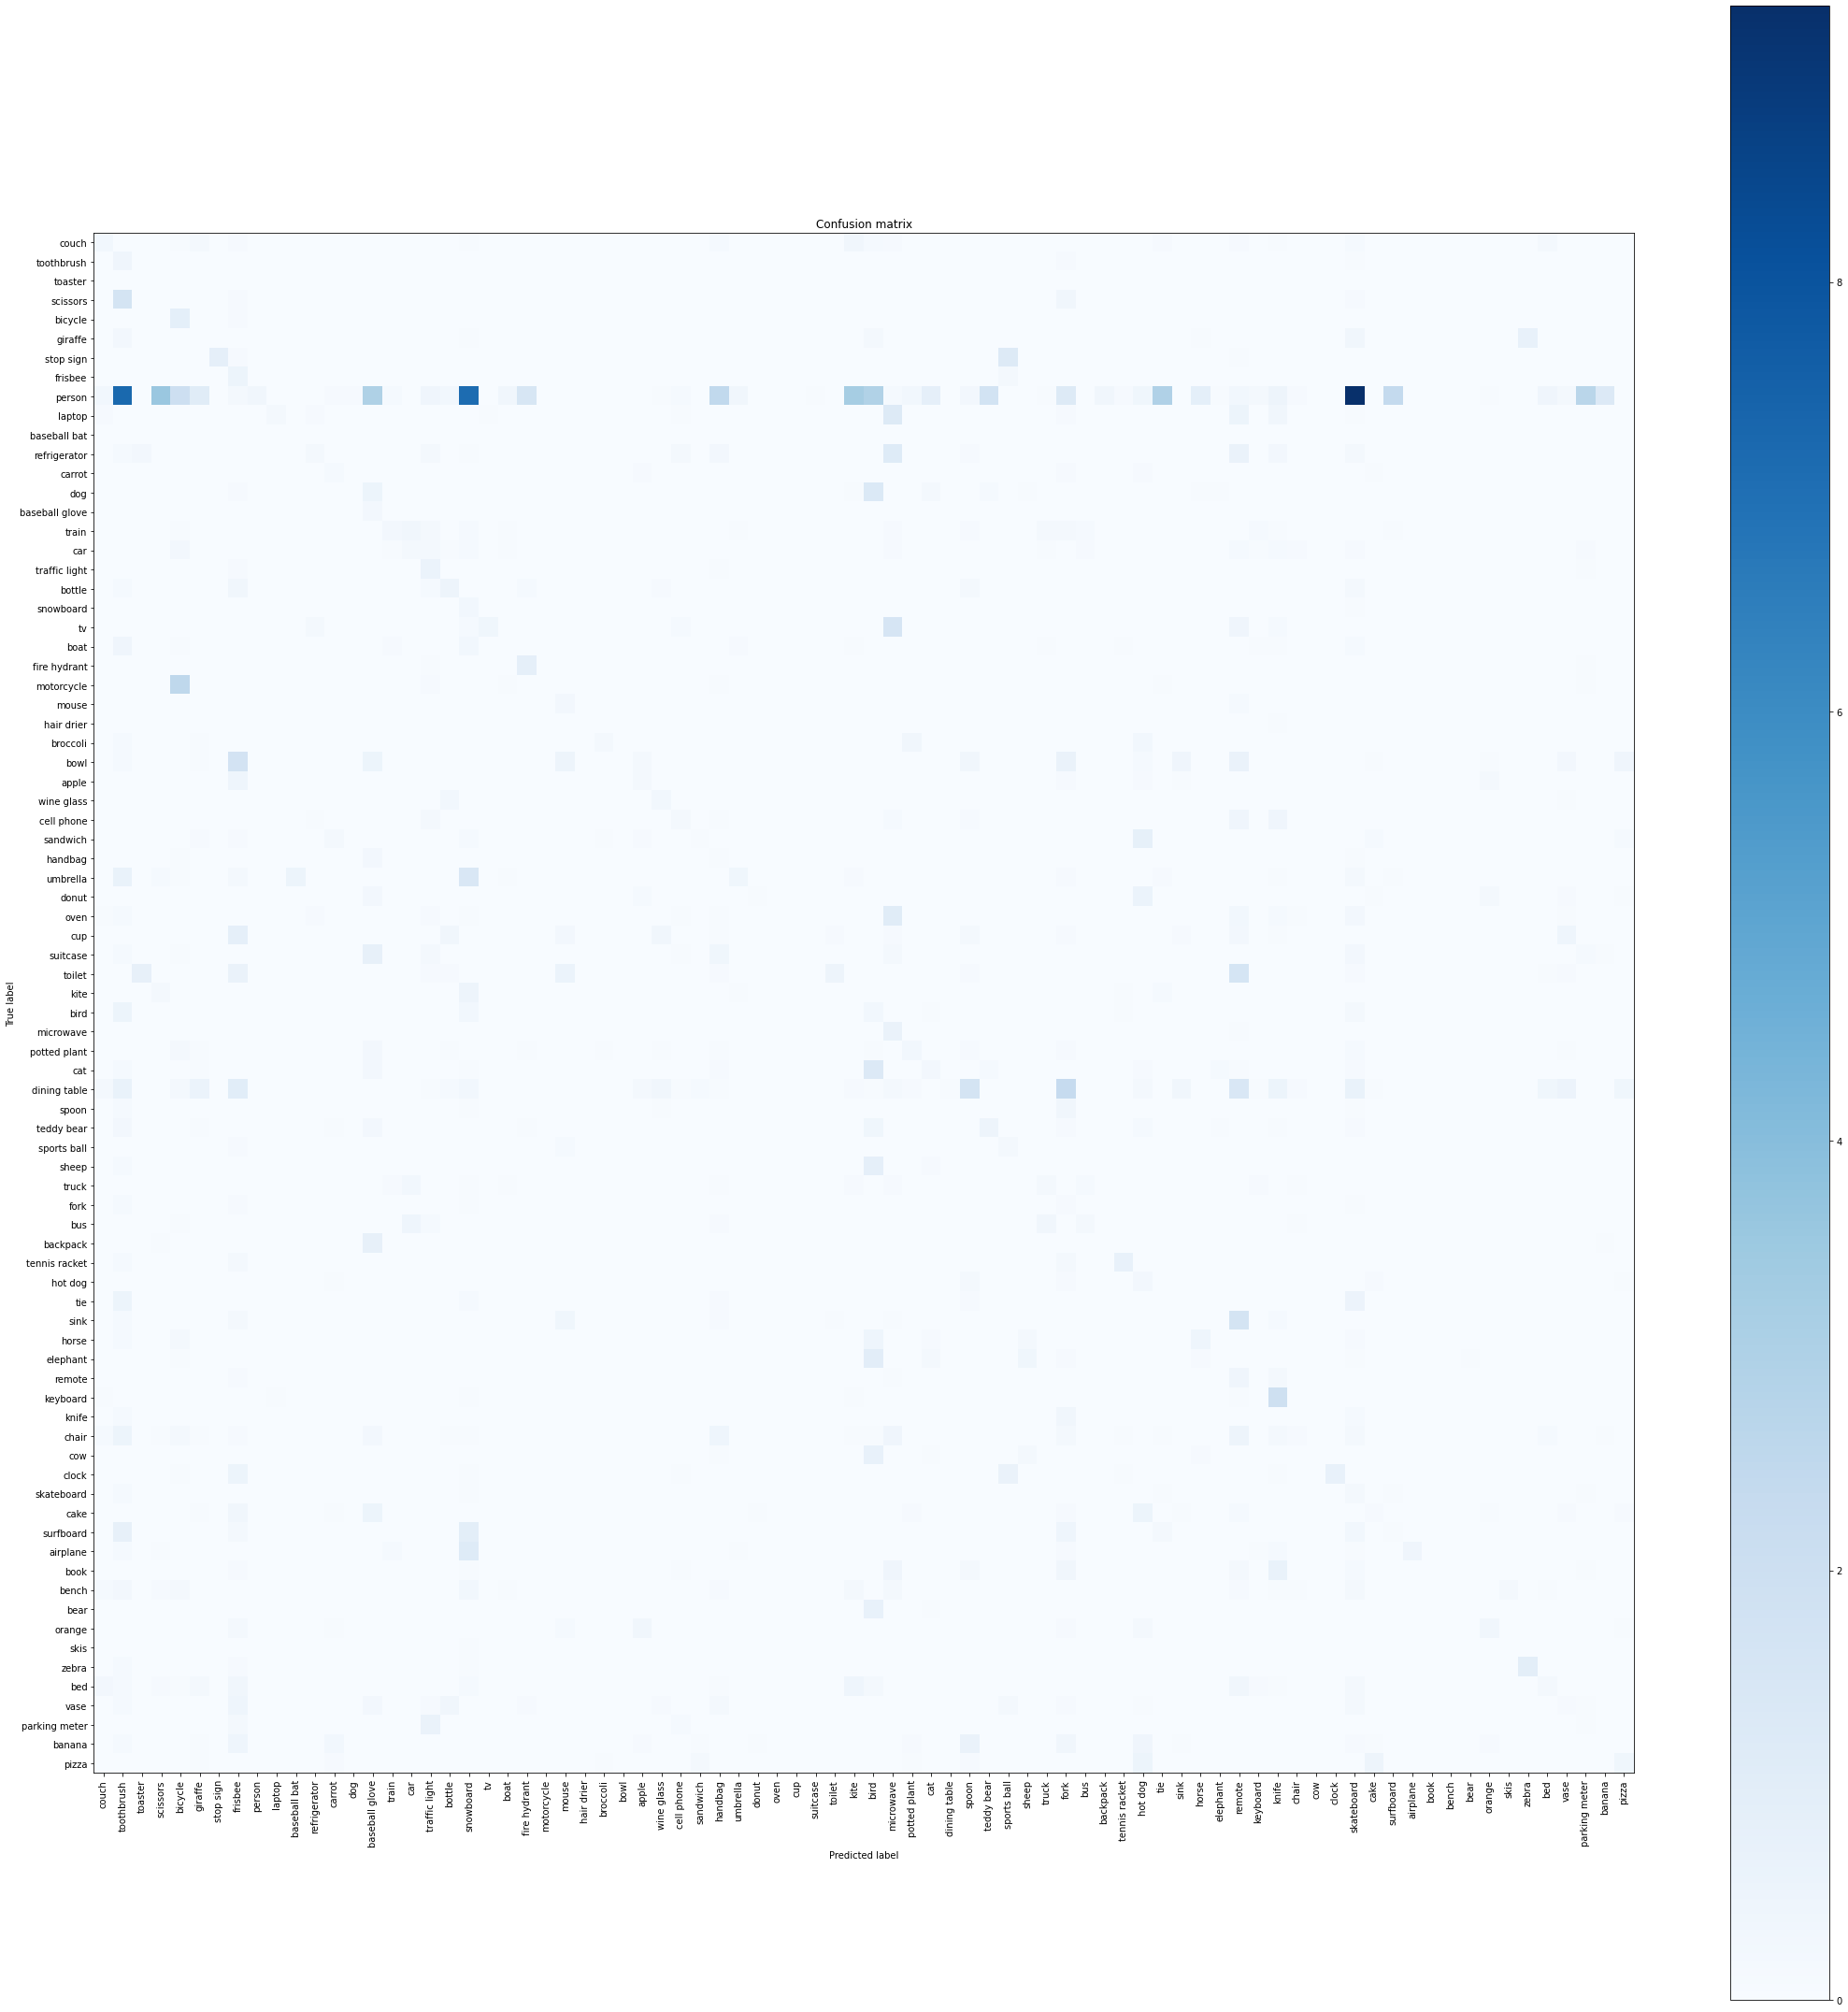

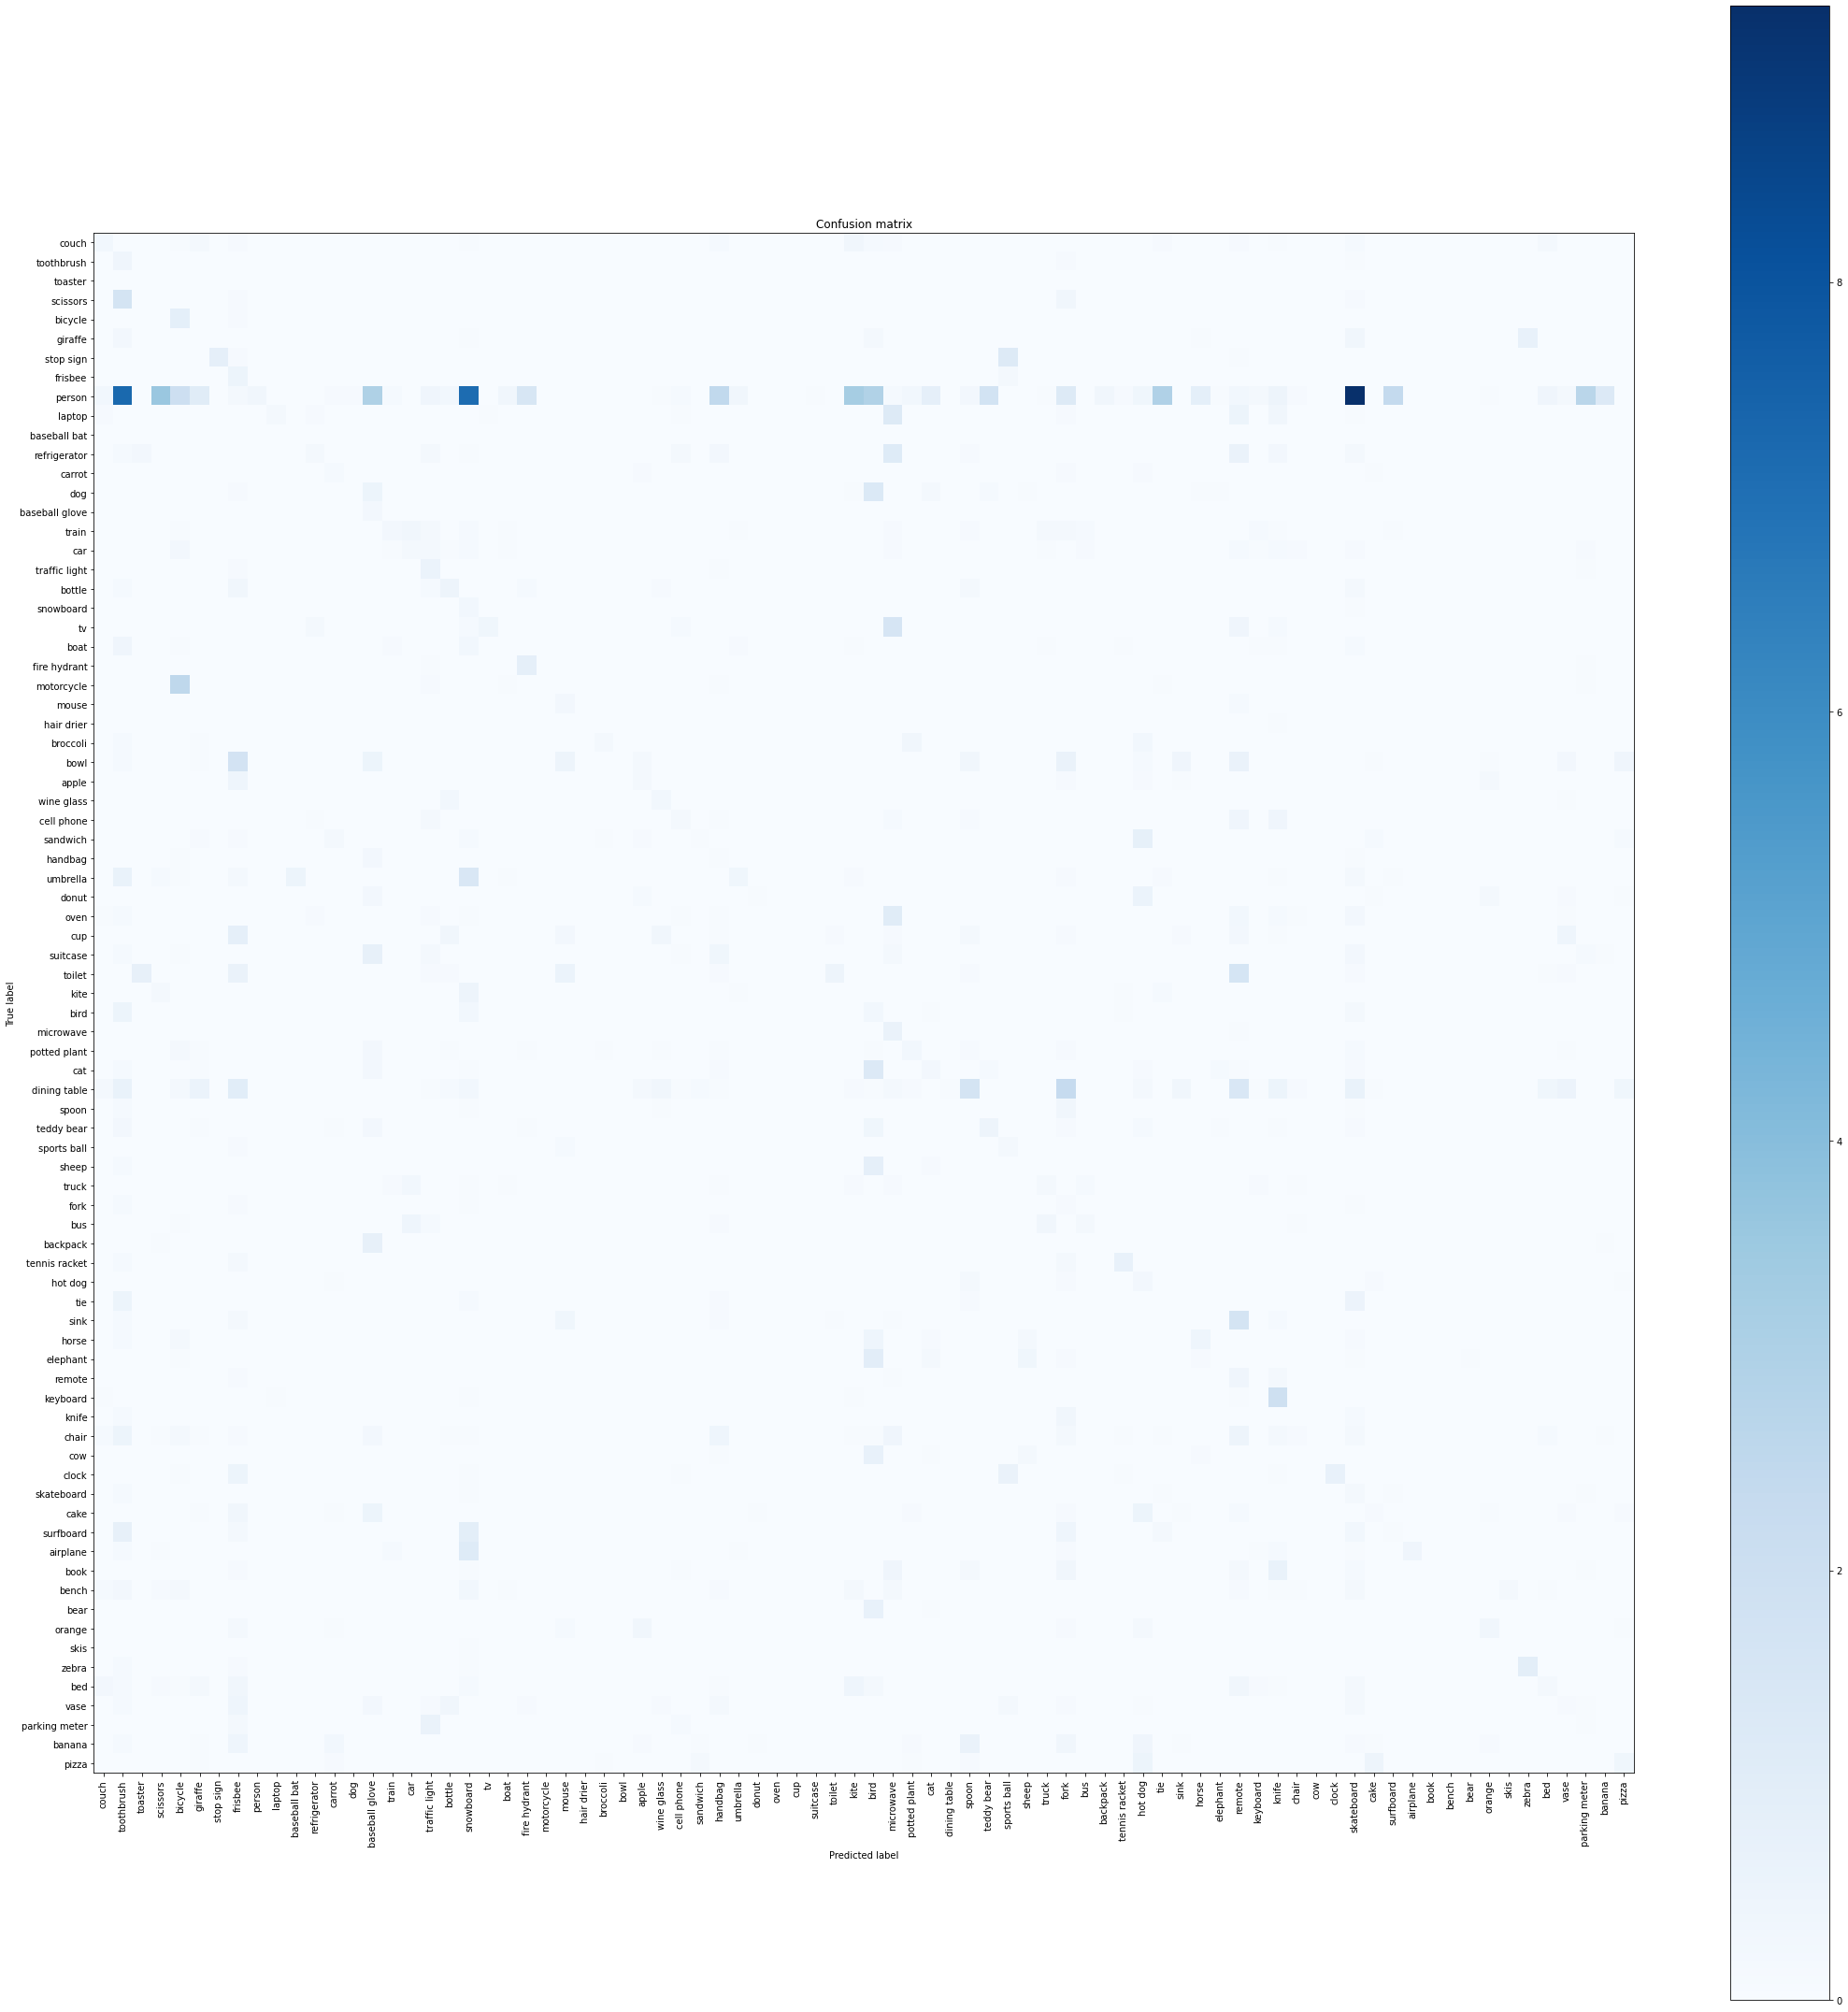

In [19]:
y = []
yhat = []

# for batch in val_data:
#     y.append([np.argmax(b) for b in batch[1]])
#     yhat.append([np.argmax(b) for b in model.predict(batch[0])])

# print(y[100])
# print(yhat[100])

# y = [x for xs in y for x in xs]
# yhat = [x for xs in yhat for x in xs]

with open('siamese_predictions1.txt') as f:
    while True:
        line = f.readline()
        if line == "":
            break
        split = line.split(':')
        y.append(int(split[0]))
        yhat.append(int(split[1]))



cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

plot_confusion_matrix(cm, coco_labels)